# Tokenization: Genius Song Lyrics Subset (1%)

**Dataset:** 51'349 Songs | 5'333 Artists | 6 Genres

**Purpose:**

---

# 1. Dataset Overview
## 1.1 Import Packages and Settings

In [3]:
import pandas as pd
import re
from collections import defaultdict, Counter
from itertools import tee
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.linear_model import LinearRegression
import os

In [4]:
plt.style.use('default')
%matplotlib inline

## 1.2 Load Dataset

In [5]:
df = pd.read_csv('data/clean/lyrics_subset_1pct_clean.csv')
df = df[df["language_cld3"] == "en"] # only english songs, better for analysis

print(f"DataFrame shape: {df.shape}")
print(f"Number of Songs: {len(df)} | Artists: {df['artist'].nunique()}")
df.head()

DataFrame shape: (34049, 11)
Number of Songs: 34049 | Artists: 26408


,title,tag,artist,year,views,features,id,language_cld3,language_ft,language,lyrics
0,2 Is Better 棍子,rap,Chris Travis,2017,4437,{},3036329,en,en,en,Bitch I'm clean Two sticks like Chow Mein Two ...
1,Scottie,rap,KrJ,2012,89,{},72180,en,en,en,My old girl left me on her old bull shit So I ...
2,Pirate Password,rock,The never land pirate band,2011,175,{},2122100,en,en,en,Avast there matey haha If a pirate asks ya for...
3,Indri,rock,Puta Volcano,2015,14,{},6889288,en,en,en,Just throw a glimpse under the shell Ghostly v...
4,Maps,misc,ANBARDA,2018,4,{},3735887,en,en,en,I miss the taste of a sweeter life I miss the ...


# 2. Tokenization
## 2.1 Build Token

In [6]:
def preprocess_text(text, lowercase=True):
    """Clean and tokenize text"""
    if not isinstance(text, str):
        return []
    if lowercase:
        text = text.lower()

    text = re.sub(r"[^a-z\s]", "", text)
    tokens = text.split()
    return tokens

preprocess_text("This is a test!")

['this', 'is', 'a', 'test']

In [7]:
df["words"] = df["lyrics"].apply(preprocess_text)
df["word_count"] = df["words"].apply(len) # words per song

df[['title','artist','word_count']].head()

,title,artist,word_count
0,2 Is Better 棍子,Chris Travis,294
1,Scottie,KrJ,199
2,Pirate Password,The never land pirate band,215
3,Indri,Puta Volcano,162
4,Maps,ANBARDA,428


In [8]:
total_lyrics = len(df)
total_words_raw = df["word_count"].sum()
avg_words_raw = df["word_count"].mean()
min_words_raw = df["word_count"].min()
max_words_raw = df["word_count"].max()

print("TEXT STATISTICS")
print("=" * 60)
print(f"Total lyrics (songs):     {total_lyrics:,}")
print(f"Total words:              {total_words_raw:,}")
print(f"Average words/lyric:      {avg_words_raw:.2f}")
print(f"Shortest lyric:           {min_words_raw} words")
print(f"Longest lyric:            {max_words_raw} words")

TEXT STATISTICS
Total lyrics (songs):     34,049
Total words:              10,596,323
Average words/lyric:      311.21
Shortest lyric:           8 words
Longest lyric:            17434 words


## 2.2 Filter Stopwords

In [9]:
STOPWORDS = {
    "the","a","an","and","or","but","if","then","so","than","that","those","these","this",
    "to","of","in","on","for","with","as","at","by","from","into","over","under","up","down",
    "is","am","are","was","were","be","been","being","do","does","did","doing","have","has","had",
    "i","you","he","she","it","we","they","me","him","her","us","them","my","your","his","its","our","their",
    "not","no","yes","yeah","y'all","yall","im","i'm","i’d","i'd","i’ll","i'll","youre","you're","dont","don't",
    "cant","can't","ill","i’ll","id","i'd","ive","i’ve","ya","oh","ooh","la","na","nah"
}

def filtered_tokens(text):
    """filter stopwords"""
    tokens = preprocess_text(text)
    return [t for t in tokens if t not in STOPWORDS and not t.isdigit() and len(t) > 1]

filtered_tokens("This is a test!")

['test']

In [10]:
df["tokens"] = df["lyrics"].apply(filtered_tokens)
tokens_per_row = df["tokens"]
tokens = [t for row in tokens_per_row for t in row]
df["token_count"] = df["tokens"].apply(len)

df[['title','artist','word_count','tokens','token_count']].head()

,title,artist,word_count,tokens,token_count
0,2 Is Better 棍子,Chris Travis,294,"[bitch, clean, two, sticks, like, chow, mein, ...",196
1,Scottie,KrJ,199,"[old, girl, left, old, bull, shit, play, off, ...",108
2,Pirate Password,The never land pirate band,215,"[avast, there, matey, haha, pirate, asks, pass...",149
3,Indri,Puta Volcano,162,"[just, throw, glimpse, shell, ghostly, voices,...",103
4,Maps,ANBARDA,428,"[miss, taste, sweeter, life, miss, conversatio...",176


In [11]:
total_lyrics = len(df)
total_tokens = len(tokens)
unique_tokens = len(set(tokens))
avg_tokens = df["token_count"].mean()
min_tokens = df["token_count"].min()
max_tokens = df["token_count"].max()

print("TOKEN STATISTICS")
print("=" * 60)
print(f"Total lyrics (songs):     {total_lyrics:,}")
print(f"Total tokens:             {total_tokens:,}")
print(f"Unique tokens:            {unique_tokens:,}")
print(f"Average tokens/lyric:     {avg_tokens:.2f}")
print(f"Shortest lyric:           {min_tokens} tokens")
print(f"Longest lyric:            {max_tokens} tokens")

TOKEN STATISTICS
Total lyrics (songs):     34,049
Total tokens:             5,999,753
Unique tokens:            127,555
Average tokens/lyric:     176.21
Shortest lyric:           4 tokens
Longest lyric:            9578 tokens


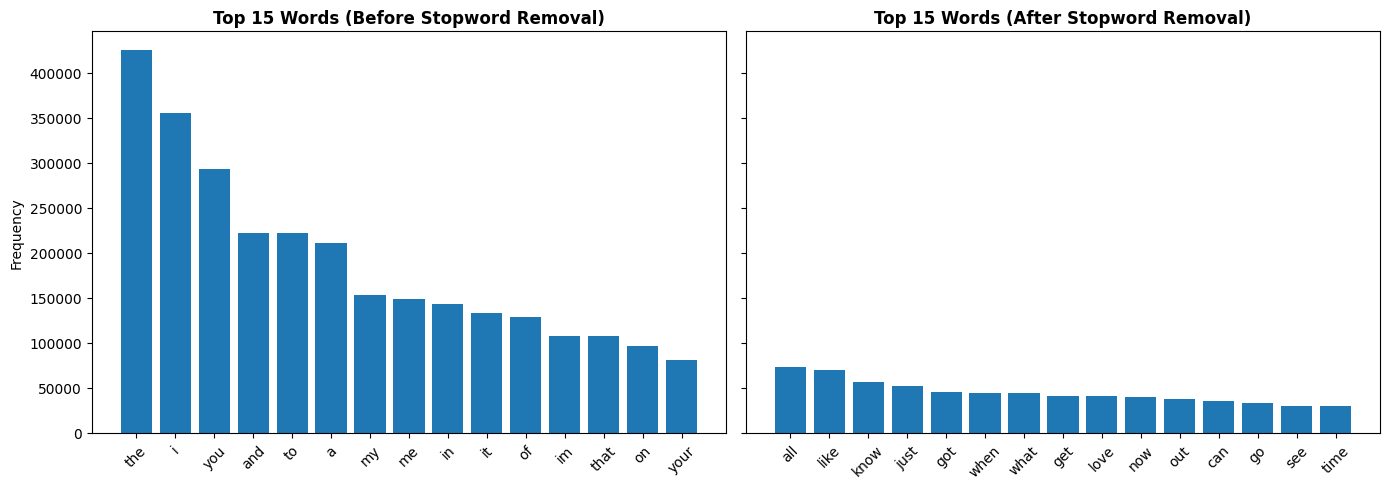

In [12]:
top_n = 15
words = [t for row in df["words"] for t in row]
tokens_filtered = [t for row in df["tokens"] for t in row]

word_counts_raw = Counter(words).most_common(top_n)
word_counts_filtered = Counter(tokens_filtered).most_common(top_n)

df_raw = pd.DataFrame(word_counts_raw, columns=["word", "count"])
df_filtered = pd.DataFrame(word_counts_filtered, columns=["word", "count"])


fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

axes[0].bar(df_raw["word"], df_raw["count"])
axes[0].set_title(f"Top {top_n} Words (Before Stopword Removal)", fontsize=12, fontweight='bold')
axes[0].set_ylabel("Frequency")
axes[0].tick_params(axis="x", rotation=45)

axes[1].bar(df_filtered["word"], df_filtered["count"])
axes[1].set_title(f"Top {top_n} Words (After Stopword Removal)", fontsize=12, fontweight='bold')
axes[1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

# 3. Save final Dataset

In [17]:
print(df.head())

             title   tag                      artist  year  views features  \
0   2 Is Better 棍子   rap                Chris Travis  2017   4437       {}   
1          Scottie   rap                         KrJ  2012     89       {}   
2  Pirate Password  rock  The never land pirate band  2011    175       {}   
3            Indri  rock                Puta Volcano  2015     14       {}   
4             Maps  misc                     ANBARDA  2018      4       {}   

        id language_cld3 language_ft language  \
0  3036329            en          en       en   
1    72180            en          en       en   
2  2122100            en          en       en   
3  6889288            en          en       en   
4  3735887            en          en       en   

                                              lyrics  \
0  Bitch I'm clean Two sticks like Chow Mein Two ...   
1  My old girl left me on her old bull shit So I ...   
2  Avast there matey haha If a pirate asks ya for...   
3  Just thro

## 3.1 Configuration

* Define output directory and file name.
* Create directory if it doesn't exist.

In [14]:
output_dir = "data/clean"
os.makedirs(output_dir, exist_ok=True)

output_path = os.path.join(output_dir, "data.csv")

# 3.2 Save Dataset locally

In [15]:
df.to_csv(output_path, index=False)

print(f"Cleaned Subset saved to: {output_path}")

Cleaned Subset saved to: data/clean/data.csv
